# 1. Setup
## 1.1 Install Dependencies

## 1.2 Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [3]:
# Avoid Out Of Memory errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# for gpu in gpus: 
#     print(gpu)

## 1.4 Create Folder Structures

In [112]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
# Make the directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors
## 2.1 Untar Labelled Faces in the Wild Dataset (get data)

In [7]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
# Dataset from: http://vis-www.cs.umass.edu/lfw/#download
!tar -xf lfw.tgz

## 2.2 Collect Positive and Anchor Classes

In [8]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [9]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        print(os.path.join('lfw', directory, file))

In [10]:
# Import uuid library to generate unique image names
import uuid

In [11]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\139b842f-330a-11ec-a6c2-4cebbd6abec6.jpg'

In [12]:
# Establish a connection to the webcam
"""
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webapcam
cap.release()
# Close the image show frames
cv2.destroyAllWindows()
"""

"\ncap = cv2.VideoCapture(0)\nwhile cap.isOpened(): \n    ret, frame = cap.read()\n   \n    # Cut down frame to 250x250px\n    frame = frame[120:120+250,200:200+250, :]\n    \n    # Collect anchors \n    if cv2.waitKey(1) & 0XFF == ord('a'):\n        # Create the unique file path \n        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))\n        # Write out anchor image\n        cv2.imwrite(imgname, frame)\n    \n    # Collect positives\n    if cv2.waitKey(1) & 0XFF == ord('p'):\n        # Create the unique file path \n        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))\n        # Write out positive image\n        cv2.imwrite(imgname, frame)\n    \n    # Show image back to screen\n    cv2.imshow('Image Collection', frame)\n    \n    # Breaking gracefully\n    if cv2.waitKey(1) & 0XFF == ord('q'):\n        break\n        \n# Release the webapcam\ncap.release()\n# Close the image show frames\ncv2.destroyAllWindows()\n"

In [13]:
# plt.imshow(frame)

# 3. Load and Preprocess Images
## 3.1 Get Image Directories

In [113]:
# Test data - 300 images
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [114]:
dir_test = anchor.as_numpy_iterator()
# Get the full path for a particular image
print(dir_test.next())

b'data\\anchor\\d4e8c5fc-2fe0-11ec-a25d-4cebbd6abec6.jpg'


## 3.2 Preprocessing - Scale and Resize

In [16]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [115]:
img = preprocess('data\\anchor\\d4e8c5fc-2fe0-11ec-a25d-4cebbd6abec6.jpg')

In [116]:
img.numpy().max() 

1.0

In [1]:
plt.imshow(img)

NameError: name 'plt' is not defined

## 3.3 Create Labelled Dataset

### (anchor, positive) => 1,1,1,1,1
### (anchor, negative) => 0,0,0,0,0
### Verified - 1
### Unverified - 0
### If it's a positive output, the array will have all ones.

In [20]:
# tf.ones(len(anchor))
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [21]:
samples = data.as_numpy_iterator()
example = samples.next()
example

(b'data\\anchor\\a9e61677-2fe0-11ec-9979-4cebbd6abec6.jpg',
 b'data\\positive\\5971dd3a-2fe1-11ec-b9ae-4cebbd6abec6.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [22]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [23]:
res = preprocess_twin(*example)

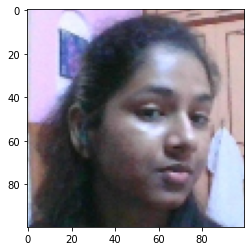

In [24]:
plt.imshow(res[0])

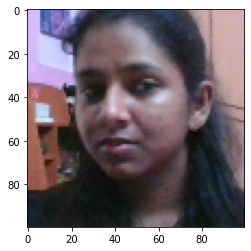

In [25]:
plt.imshow(res[1])

In [26]:
res[2]

1.0

In [27]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [118]:
samples = data.as_numpy_iterator()
samp = samples.next()

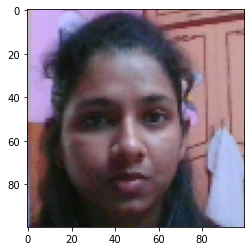

In [119]:
plt.imshow(samp[0])

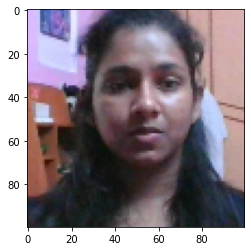

In [120]:
plt.imshow(samp[1])

In [121]:
samp[2]

1.0

In [32]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [33]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering
## 4.1 Build Embedding Layer

In [34]:
inp = Input(shape=(100,100,3), name='input_image')

In [35]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [36]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [37]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [38]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [39]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [40]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [41]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block - 128 filters with the shape of 7x7
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [42]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

## 4.2 Build Distance Layer

In [43]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [44]:
l1 = L1Dist()

## 4.3 Make Siamese Model

In [45]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [46]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [47]:
siamese_layer = L1Dist()

In [48]:
distances = siamese_layer(inp_embedding, val_embedding)

In [49]:
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [50]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [51]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [52]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

# 5. Training
## 5.1 Setup Loss and Optimizer

In [53]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [54]:
# Using Adam Optimiser
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [55]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [56]:
test_batch = train_data.as_numpy_iterator()

In [57]:
batch_1 = test_batch.next()

In [58]:
X = batch_1[:2]
y = batch_1[2]
y

array([0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
      dtype=float32)

In [59]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

## 5.4 Build Training Loop
#### While the train_step function focuses on training one batch, the loop here will be used to iterate over every batch in the dataset.

In [60]:
# Data and number of EPOCHS - input
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [61]:
EPOCHS = 50

In [62]:
# train(train_data, EPOCHS)

# 6. Evaluate Model

## 6.1 Import Metrics

In [63]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

#### Note: Precision and recall are 2 different metrics which help us calculate the similarity between 2 images. (0-1)
#### Difference between precision and Recall: Precision demonstrates what propertion of positive 
#### identification were actually correct, Recall shows what proportion of actual positives were identified correctly

## 6.2 Make Predicitons

In [99]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [106]:
test_var = test_data.as_numpy_iterator().next()

In [107]:
len(test_var)

3

In [108]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[0.49852794],
       [0.4998553 ],
       [0.49762657],
       [0.50078225],
       [0.49834213],
       [0.5001669 ],
       [0.5006312 ],
       [0.4991004 ],
       [0.49909976],
       [0.4988293 ],
       [0.4998562 ],
       [0.49944627],
       [0.49966565],
       [0.50009507],
       [0.50007147],
       [0.49984297]], dtype=float32)

In [109]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]

In [110]:
y_true

array([0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [111]:
# Creating a metric object - Recall
m = Recall()

# Calculating a recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.25

In [98]:
# Creating a metric object - Precision
m = Precision()

# Calculating a recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.4

## 6.4 Visualize Results

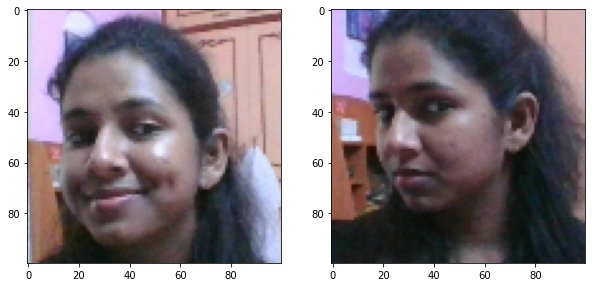

In [90]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[3])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

plt.show()

# 7. Save Model

In [73]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [74]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [75]:
# tf.keras.models.load_model??

In [76]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

array([[0.49876252],
       [0.49965817],
       [0.49984297],
       [0.5008297 ],
       [0.49892524],
       [0.49955028],
       [0.5003456 ],
       [0.500762  ],
       [0.49944082],
       [0.49879757],
       [0.49953228],
       [0.500142  ],
       [0.49966654],
       [0.49936032],
       [0.49920002],
       [0.49994323]], dtype=float32)

In [77]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_3 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8. Real Time Test

## 8.1 Verification Function

In [78]:
os.listdir(os.path.join('application_data', 'verification_images'))

['51a14a00-2fe1-11ec-a419-4cebbd6abec6.jpg',
 '51c524e9-2fe1-11ec-a3bd-4cebbd6abec6.jpg',
 '51fc15f6-2fe1-11ec-81ae-4cebbd6abec6.jpg',
 '52b042aa-2fe1-11ec-8dbc-4cebbd6abec6.jpg',
 '53298a58-2fe1-11ec-9542-4cebbd6abec6.jpg',
 '55593cb3-2fe1-11ec-b3fb-4cebbd6abec6.jpg',
 '57eaac29-2fe1-11ec-b621-4cebbd6abec6.jpg',
 '580dfc79-2fe1-11ec-8ff4-4cebbd6abec6.jpg',
 '581c17df-2fe1-11ec-836d-4cebbd6abec6.jpg',
 '5971dd3a-2fe1-11ec-b9ae-4cebbd6abec6.jpg',
 '5a5a0eb7-2fe1-11ec-9d93-4cebbd6abec6.jpg',
 '5ac514f0-2fe1-11ec-b2f4-4cebbd6abec6.jpg',
 '5af76ad5-2fe1-11ec-92a7-4cebbd6abec6.jpg',
 '6b86382f-2fe1-11ec-8875-4cebbd6abec6.jpg',
 '6ba509cf-2fe1-11ec-9ebc-4cebbd6abec6.jpg',
 '6bc3b3b8-2fe1-11ec-8db4-4cebbd6abec6.jpg',
 '6bd8fe17-2fe1-11ec-aa14-4cebbd6abec6.jpg',
 '6be6fdc1-2fe1-11ec-acc1-4cebbd6abec6.jpg',
 '6d118cd2-2fe1-11ec-9446-4cebbd6abec6.jpg',
 '6d34c16e-2fe1-11ec-b778-4cebbd6abec6.jpg',
 '82a1b8be-2fe1-11ec-aed8-4cebbd6abec6.jpg',
 '82a8de15-2fe1-11ec-8d02-4cebbd6abec6.jpg',
 '82d080b5

In [79]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make predictions
        # Wrapped up in list since we have only 1 input_image
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    return results, verified
    
    # Metrics above which a prediction is considered positive - Detection threshold
    # Proportion of positive predictions / total positive samples - Verification threshold 

## 8.2 OpenCV Real Time Verification

In [80]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    cv2.imshow('Verification', frame)
    
    # Verification trigger - click 'v'
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to spplication_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.5, 0.55)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

False


In [81]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_3 (L1Dist)              (None, 4096)         0           embedding[0][0]     